In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
def go_up(location , width):
    if location - width < 0:
        new_location = location
    else:
        new_location = location - width
    return new_location

def go_down(location, width, height):
    if location + width > height * width - 1:
        new_location = location
    else:
        new_location = location + width
    return new_location

def go_left(location, width):
    if location % width == 0:
        new_location = location
    else:
        new_location = location - 1
    return new_location

def go_right(location, width):
    if (location + 1) % width == 0:
        new_location = location
    else:
        new_location = location + 1
    return new_location

def move(action , location , width , height):
    if action  == 0:  #UP
        new_location =  go_up(location= location , width= width)
    elif action == 1: #DOWN
        new_location =  go_down(location= location , width= width , height= height)
    elif action == 2: #LEFT
        new_location = go_left(location= location , width= width)
    elif action == 3: #RIGHT
        new_location =  go_right(location= location, width= width)
    return new_location

class environment:
    def __init__(self, grid_height, grid_width):
        self.height = grid_height
        self.width = grid_width
        self.start = []
        self.end = []
        self.reward = []
        self.map = np.array([i for i in range(grid_height * grid_width)])
        self.action_space = [0,1,2,3]

    def get_Map(self):
        print(self.map.reshape([self.width, self.height]))

    def get_NumState(self):
        return self.height * self.width

    def map_Designate(self, start_cell, end_cell, reward):
        self.start.append(start_cell)
        self.end.append(end_cell)
        self.reward.append(reward)

    def get_Observation(self, location, action):
        reward = 0
        new_location = 0
        # Action: UP: 0, DOWN: 1, LEFT: 2, RIGHT: 3        
        new_location = move(action=action , location= location , width= self.width ,height= self.height)

        # If the agent is at special locations, immediately moves to corresponding destinations, gain reward
        if new_location in self.start:
            idx = self.start.index(new_location)
            new_location = self.end[idx]
            reward = self.reward[idx]
        
        return new_location, self.action_space, reward


class MAB_agent:
    def __init__(self, envir, init_location):
        self.reward_trace = []
        self.location_now = init_location
        self.lastAction = None
        self.lastLocation = 0
        self.value_table = {}    # format: {state : {action : [value, count]}}
        for state in range(envir.width*envir.height):
            self.value_table[state] = {}
            for action in envir.action_space:
                self.value_table[state][action] = [0,0]

    def get_TotalReward(self):
        return np.sum(self.reward_trace)

In [29]:
# Create environment
Envir = environment(8,8)
Envir.map_Designate(17,56,-15)
Envir.map_Designate(18,56,-15)
Envir.map_Designate(19,56,-15)
Envir.map_Designate(21,56,-15)
Envir.map_Designate(25,56,-15)
Envir.map_Designate(33,56,-15)
Envir.map_Designate(41,56,-15)
Envir.map_Designate(42,56,-15)
Envir.map_Designate(43,56,-15)
Envir.map_Designate(46,56,-15)
Envir.map_Designate(47,56,-15)
Envir.map_Designate(47,56,-15)
Envir.map_Designate(15,56,+15)
Envir.map_Designate(1,10,+5)
Envir.map_Designate(26,56,+20)

Envir.get_Map()

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]


## Q_learning

In [30]:
class Q_agent (MAB_agent):
    def __init__(self, envir:environment, init_location , learning_rate , discount_factor , epsilon):
        super().__init__(envir, init_location)
        self.Q_table = {}
        for state in range(envir.width * envir.height):
            self.Q_table[state] = {}
            for action in envir.action_space:
                self.Q_table[state][action] = [0,0]
                
        self.gamma = discount_factor
        self.alpha = learning_rate
        self.epsilon = epsilon
    
    
    def getAction(self, observation):
        self.location_now, action_space, pre_reward = observation
        if pre_reward is None:
            while True:
                action = np.random.choice(action_space)
                tmp = move(action=action, location=self.location_now, width=Envir.width, height=Envir.height)
                if tmp != self.location_now:
                    break
        else:
            max_val = -0.000001
            if np.random.uniform(0,1) < self.epsilon:
                while True:
                    action = np.random.choice(action_space)
                    tmp = move(action=action, location=self.location_now, width=Envir.width, height=Envir.height)
                    if tmp != self.location_now :
                        break
            else:
                for i in action_space:
                    tmp = move(action=i, location=self.location_now, width=Envir.width, height=Envir.height)
                    if tmp != self.location_now:
                        if self.Q_table[self.location_now][i][0] > max_val:
                            max_val = self.Q_table[self.location_now][i][0]
                            action = i
            
            self.reward_trace.append(pre_reward)
            # update Q table
            self.Q_table[self.lastLocation][self.lastAction][0] = (1 - self.alpha) * self.Q_table[self.lastLocation][self.lastAction][0] + self.alpha * (pre_reward + self.gamma * max_val)
        self.Q_table[self.location_now][action][1] += 1
        self.lastLocation = self.location_now
        self.lastAction = action
        return action

In [31]:
init_location=0
dummy_q_agent = Q_agent(envir=Envir, init_location=init_location, learning_rate=0.8, discount_factor=0.8, epsilon=0.3)

num_iter = 100000

log_freq = 1000
Data_plot1 = []

for i in range(num_iter):
    if i == 0:
        env_observation = (init_location, Envir.action_space, None)
    else:
        env_observation = Envir.get_Observation(location=dummy_q_agent.location_now, action=chosen_action)

    chosen_action = dummy_q_agent.getAction(observation=env_observation)

    if (i + 1) % log_freq == 0:
        aver = np.mean(dummy_q_agent.reward_trace)
        Data_plot1.append(aver)
        print('iter: ' + str(i + 1) + '\t Total reward: ' + str(dummy_q_agent.get_TotalReward()) + '\t Average: ' + str(aver))

iter: 1000	 Total reward: -505	 Average: -0.5055055055055055
iter: 2000	 Total reward: -740	 Average: -0.37018509254627313
iter: 3000	 Total reward: -940	 Average: -0.3134378126042014
iter: 4000	 Total reward: -1165	 Average: -0.2913228307076769
iter: 5000	 Total reward: -915	 Average: -0.1830366073214643
iter: 6000	 Total reward: -950	 Average: -0.1583597266211035
iter: 7000	 Total reward: -1065	 Average: -0.15216459494213458
iter: 8000	 Total reward: -1305	 Average: -0.16314539317414678
iter: 9000	 Total reward: -1295	 Average: -0.1439048783198133
iter: 10000	 Total reward: -1245	 Average: -0.12451245124512451
iter: 11000	 Total reward: -990	 Average: -0.09000818256205109
iter: 12000	 Total reward: -675	 Average: -0.05625468789065755
iter: 13000	 Total reward: -870	 Average: -0.06692822524809601
iter: 14000	 Total reward: -970	 Average: -0.06929066361882992
iter: 15000	 Total reward: -945	 Average: -0.06300420028001867
iter: 16000	 Total reward: -1015	 Average: -0.06344146509156823
i

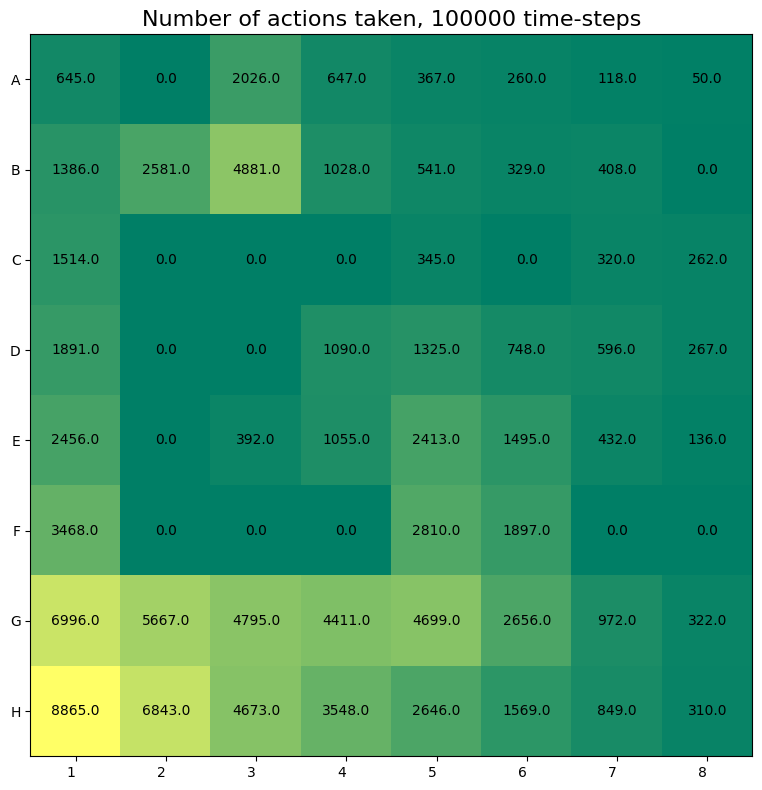

In [32]:
Y_Cord = ["A", "B", "C", "D", "E", "F", "G", "H"]
X_Cord = ["1", "2", "3", "4", "5", "6", "7", "8"]

# Map = freq_list.reshape([Envir.width, Envir.height])
Map = np.zeros([Envir.width, Envir.height])
for i in range(Envir.height):
  for j in range(Envir.width):
    state = i * Envir.width + j
    if state in dummy_q_agent.Q_table.keys():
      list_freq = [f[1] for f in dummy_q_agent.Q_table[state].values()]
      Map[i][j] = sum(list_freq)
    else:
      Map[i][j] = 0

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(Map, cmap="summer")

ax.set_xticks(np.arange(len(X_Cord)))
ax.set_yticks(np.arange(len(Y_Cord)))

ax.set_xticklabels(X_Cord)
ax.set_yticklabels(Y_Cord)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(Y_Cord)):
    for j in range(len(X_Cord)):
        text = ax.text(j, i, Map[i, j],ha="center", va="center", color="k")

ax.set_title("Number of actions taken, " + str(num_iter) + " time-steps", fontdict={'size':16})
# ax.set_xlabel("Alpha = " + str(learning_rate) + " Gamma = " + str(discount_factor))
fig.tight_layout()
plt.show()

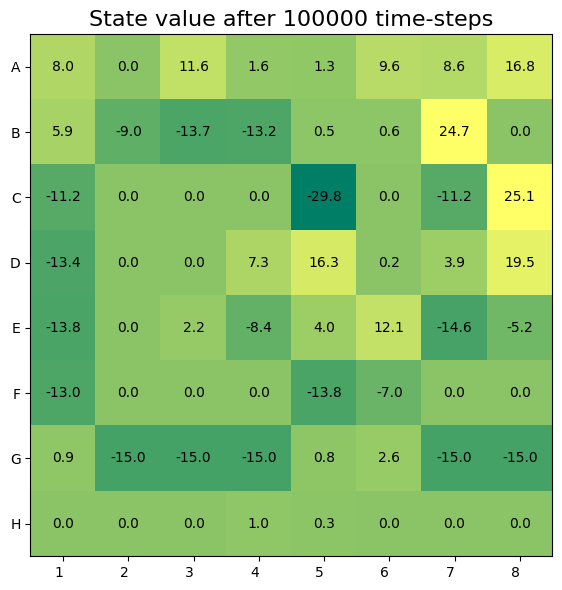

In [33]:
Y_Cord = ["A", "B", "C", "D", "E", "F", "G", "H"]
X_Cord = ["1", "2", "3", "4", "5", "6", "7", "8"]
# agent = dummyAgent_e

# Map = freq_list.reshape([Envir.width, Envir.height])
Map = np.zeros([Envir.width, Envir.height])
for i in range(Envir.height):
  for j in range(Envir.width):
    state = i * Envir.width + j
    if state in dummy_q_agent.Q_table.keys():
      list_value = [round(f[0],1) for f in dummy_q_agent.Q_table[state].values()]
      Map[i][j] = round(sum(list_value),1)
    else:
      Map[i][j] = 0

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(Map, cmap="summer")

# We want to show all ticks...
ax.set_xticks(np.arange(len(X_Cord)))
ax.set_yticks(np.arange(len(Y_Cord)))
# ... and label them with the respective list entries
ax.set_xticklabels(X_Cord)
ax.set_yticklabels(Y_Cord)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(Y_Cord)):
    for j in range(len(X_Cord)):
        text = ax.text(j, i, Map[i, j],ha="center", va="center", color="k")

ax.set_title("State value after " + str(num_iter) + " time-steps", fontdict={'size':16})
# ax.set_xlabel("Alpha = " + str(learning_rate) + " Gamma = " + str(discount_factor))
fig.tight_layout()
plt.show()

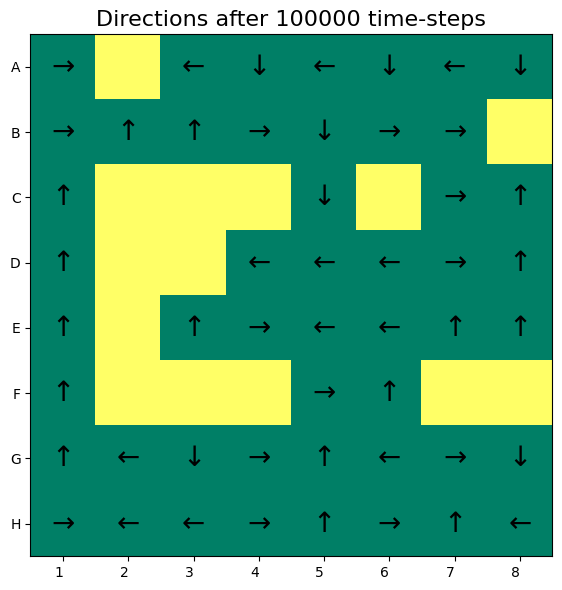

In [34]:
Y_Cord = ["A", "B", "C", "D", "E", "F", "G", "H"]
X_Cord = ["1", "2", "3", "4", "5", "6", "7", "8"]


def decode_action(action):
  if action == 0: #UP
    return "\u2191"
  if action == 1: #DOWN
    return "\u2193"
  if action == 2: #LEFT
    return "\u2190"
  return "\u2192" #RIGHT

Map = np.zeros([Envir.width, Envir.height])
Map_labels = [['' for _ in range(Envir.width)] for _ in range(Envir.height)]
for i in range(Envir.height):
  for j in range(Envir.width):
    state = i * Envir.width + j
    if state in dummy_q_agent.Q_table.keys():
      list_value = [f[0] for f in dummy_q_agent.Q_table[state].values()]
      max_value = max(list_value)
      actions = [index for index, value in enumerate(list_value) if value == max_value]
      if len(actions) > 1:
        Map_labels[i][j] = ''
        Map[i][j] = 1
      else:
        Map_labels[i][j] = decode_action(actions[0])
        Map[i][j] = 0

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(Map,cmap='summer')

# We want to show all ticks...
ax.set_xticks(np.arange(len(X_Cord)))
ax.set_yticks(np.arange(len(Y_Cord)))
# ... and label them with the respective list entries
ax.set_xticklabels(X_Cord)
ax.set_yticklabels(Y_Cord)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(Y_Cord)):
    for j in range(len(X_Cord)):
        text = ax.text(j, i, Map_labels[i][j],ha="center", va="center", color="k",fontsize=20)

ax.set_title("Directions after " + str(num_iter) + " time-steps", fontdict={'size':16})
# ax.set_xlabel("Alpha = " + str(learning_rate) + " Gamma = " + str(discount_factor))
fig.tight_layout()
plt.show()

## Expected SARSA

In [35]:
class eSARSA_agent(MAB_agent):
    def __init__(self, envir , init_location , learning_rate , discount_factor , epsilon):
        super(eSARSA_agent , self).__init__(envir= envir , init_location= init_location)
        self.Q_table = {}   # format: {state : {action : [value, count]}}
        for state in range(envir.width*envir.height):
            self.Q_table[state] = {}
            for action in envir.action_space:
                self.Q_table[state][action] = [0,0]
        self.alpha = learning_rate          
        self.gamma = discount_factor        
        self.epsilon = epsilon
        
    """ def getAction(self, observation):
        self.location_now, action_space, pre_reward = observation
        if pre_reward is None:
            while True:
                action = np.random.choice(action_space)
                tmp = move(action=action, location=self.location_now, width=Envir.width, height=Envir.height)
                if tmp != self.location_now:
                    break
        else:
            # get action based on policy
            max_val = -0.000001
            if np.random.uniform(0,1) < self.epsilon:
                while True:
                    action = np.random.choice(action_space)
                    tmp = move(action=action, location=self.location_now, width=Envir.width, height=Envir.height)
                    if tmp != self.location_now :
                        break
            else:
                for i in action_space:
                    tmp = move(action=i, location=self.location_now, width=Envir.width, height=Envir.height)
                    if tmp != self.location_now:
                        if self.Q_table[self.location_now][i][0] > max_val:
                            max_val = self.Q_table[self.location_now][i][0]
                            action = i
            self.reward_trace.append(pre_reward)
            # update Q table
            self.Q_table[self.lastLocation][self.lastAction][0] = (1 - self.alpha) * self.Q_table[self.lastLocation][self.lastAction][0] + self.alpha * (pre_reward + self.gamma * max_val)
        self.Q_table[self.location_now][action][1] += 1
        self.lastLocation = self.location_now
        self.lastAction = action
        return action """
    
    
    def getAction(self, observation):
        self.location_now, action_space, pre_reward = observation

        if pre_reward is None:
            while True:
                action = np.random.choice(action_space)
                tmp = move(action=action, location=self.location_now, width=Envir.width, height=Envir.height)
                if tmp != self.location_now:
                    break
        else:
            # Chọn hành động tại trạng thái hiện tại theo epsilon-greedy
            if np.random.uniform(0, 1) < self.epsilon:
                while True:
                    action = np.random.choice(action_space)
                    tmp = move(action=action, location=self.location_now, width=Envir.width, height=Envir.height)
                    if tmp != self.location_now:
                        break
            else:
                max_val = -float('inf')
                for i in action_space:
                    tmp = move(action=i, location=self.location_now, width=Envir.width, height=Envir.height)
                    if tmp != self.location_now:
                        if self.Q_table[self.location_now][i][0] > max_val:
                            max_val = self.Q_table[self.location_now][i][0]
                            action = i

            next_state = move(action=action, location=self.location_now, width=Envir.width, height=Envir.height)
            
            # Chọn hành động tiếp theo cho trạng thái mới theo epsilon-greedy
            if np.random.uniform(0, 1) < self.epsilon:
                while True:
                    next_action = np.random.choice(action_space)
                    tmp = move(action=next_action, location=next_state, width=Envir.width, height=Envir.height)
                    if tmp != next_state:
                        break
            else:
                max_val_next = -float('inf')
                for i in action_space:
                    tmp = move(action= i , location= next_state , width= Envir.width , height= Envir.height)
                    if tmp != next_state:
                        if self.Q_table[next_state][i][0] > max_val_next:
                            max_val_next = self.Q_table[next_state][i][0]
                            next_action = i

            # Cập nhật Q-table theo công thức SARSA
            self.Q_table[self.location_now][action][0] = (1 - self.alpha) * self.Q_table[self.location_now][action][0] + self.alpha * (pre_reward + self.gamma * self.Q_table[next_state][next_action][0])
            self.Q_table[self.lastLocation][self.lastAction][0] = (1 - self.alpha) * self.Q_table[self.lastLocation][self.lastAction][0] + self.alpha * (pre_reward + self.gamma * self.Q_table[self.location_now][action][0])
            
            # Cập nhật lại Q-table
            self.reward_trace.append(pre_reward)

            # Cập nhật số lần thực hiện hành động
            self.Q_table[self.location_now][action][1] += 1

        # Cập nhật thông tin trạng thái và hành động
        self.lastLocation = self.location_now
        self.lastAction = action
        
        return action
    

In [36]:
init_location=0
dummy_esarsa_agent = eSARSA_agent(envir=Envir, init_location=init_location, learning_rate=0.8, discount_factor=0.8, epsilon=0.3)

num_iter = 100000

log_freq = 1000
Data_plot2 = []

for i in range(num_iter):
    if i == 0:
        env_observation = (init_location, Envir.action_space, None)
    else:
        env_observation = Envir.get_Observation(location=dummy_esarsa_agent.location_now, action=chosen_action)

    chosen_action = dummy_esarsa_agent.getAction(env_observation)

    if (i + 1) % log_freq == 0:
        aver = np.mean(dummy_esarsa_agent.reward_trace)
        Data_plot2.append(aver)
        print('iter: ' + str(i + 1) + '\t Total reward: ' + str(dummy_esarsa_agent.get_TotalReward()) + '\t Average: ' + str(aver))

iter: 1000	 Total reward: -590	 Average: -0.5905905905905906
iter: 2000	 Total reward: -475	 Average: -0.23761880940470234
iter: 3000	 Total reward: -615	 Average: -0.20506835611870625
iter: 4000	 Total reward: -690	 Average: -0.17254313578394598
iter: 5000	 Total reward: -695	 Average: -0.13902780556111222
iter: 6000	 Total reward: -960	 Average: -0.16002667111185198
iter: 7000	 Total reward: -885	 Average: -0.1264466352336048
iter: 8000	 Total reward: -955	 Average: -0.11938992374046756
iter: 9000	 Total reward: -1080	 Average: -0.12001333481497944
iter: 10000	 Total reward: -975	 Average: -0.09750975097509751
iter: 11000	 Total reward: -1095	 Average: -0.0995545049549959
iter: 12000	 Total reward: -1280	 Average: -0.10667555629635803
iter: 13000	 Total reward: -1345	 Average: -0.10346949765366567
iter: 14000	 Total reward: -1460	 Average: -0.1042931637974141
iter: 15000	 Total reward: -1710	 Average: -0.11400760050670045
iter: 16000	 Total reward: -1980	 Average: -0.1237577348584286

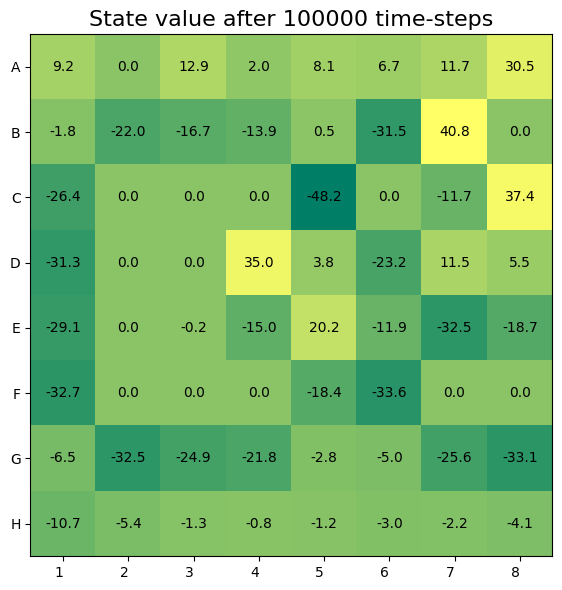

In [37]:
Y_Cord = ["A", "B", "C", "D", "E", "F", "G", "H"]
X_Cord = ["1", "2", "3", "4", "5", "6", "7", "8"]
# agent = dummyAgent_e

# Map = freq_list.reshape([Envir.width, Envir.height])
Map = np.zeros([Envir.width, Envir.height])
for i in range(Envir.height):
  for j in range(Envir.width):
    state = i * Envir.width + j
    if state in dummy_esarsa_agent.Q_table.keys():
      list_value = [round(f[0],1) for f in dummy_esarsa_agent.Q_table[state].values()]
      Map[i][j] = round(sum(list_value),1)
    else:
      Map[i][j] = 0

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(Map, cmap="summer")

# We want to show all ticks...
ax.set_xticks(np.arange(len(X_Cord)))
ax.set_yticks(np.arange(len(Y_Cord)))
# ... and label them with the respective list entries
ax.set_xticklabels(X_Cord)
ax.set_yticklabels(Y_Cord)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(Y_Cord)):
    for j in range(len(X_Cord)):
        text = ax.text(j, i, Map[i, j],
                       ha="center", va="center", color="k")

ax.set_title("State value after " + str(num_iter) + " time-steps", fontdict={'size':16})
# ax.set_xlabel("Alpha = " + str(learning_rate) + " Gamma = " + str(discount_factor))
fig.tight_layout()
plt.show()

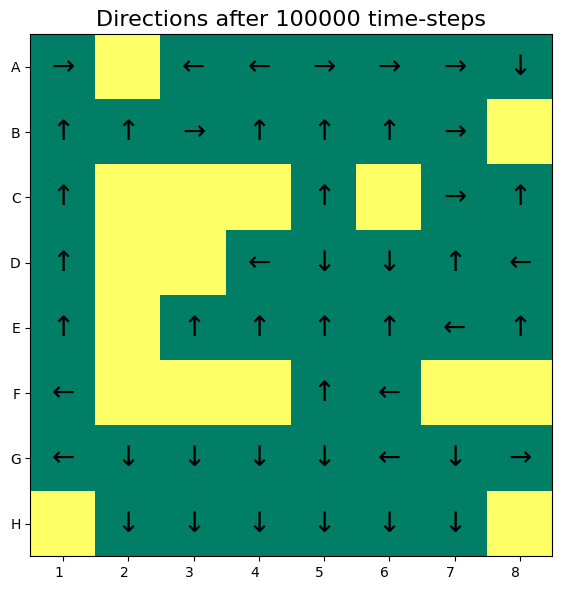

In [38]:
Y_Cord = ["A", "B", "C", "D", "E", "F", "G", "H"]
X_Cord = ["1", "2", "3", "4", "5", "6", "7", "8"]


def decode_action(action):
  if action == 0: #UP
    return "\u2191"
  if action == 1: #DOWN
    return "\u2193"
  if action == 2: #LEFT
    return "\u2190"
  return "\u2192" #RIGHT

Map = np.zeros([Envir.width, Envir.height])
Map_labels = [['' for _ in range(Envir.width)] for _ in range(Envir.height)]
for i in range(Envir.height):
  for j in range(Envir.width):
    state = i * Envir.width + j
    if state in dummy_esarsa_agent.Q_table.keys():
      list_value = [f[0] for f in dummy_esarsa_agent.Q_table[state].values()]
      max_value = max(list_value)
      actions = [index for index, value in enumerate(list_value) if value == max_value]
      if len(actions) > 1:
        Map_labels[i][j] = ''
        Map[i][j] = 1
      else:
        Map_labels[i][j] = decode_action(actions[0])
        Map[i][j] = 0

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(Map,cmap='summer')

# We want to show all ticks...
ax.set_xticks(np.arange(len(X_Cord)))
ax.set_yticks(np.arange(len(Y_Cord)))
# ... and label them with the respective list entries
ax.set_xticklabels(X_Cord)
ax.set_yticklabels(Y_Cord)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(Y_Cord)):
    for j in range(len(X_Cord)):
        text = ax.text(j, i, Map_labels[i][j],
                       ha="center", va="center", color="k",fontsize=20)

ax.set_title("Directions after " + str(num_iter) + " time-steps", fontdict={'size':16})
# ax.set_xlabel("Alpha = " + str(learning_rate) + " Gamma = " + str(discount_factor))
fig.tight_layout()
plt.show()

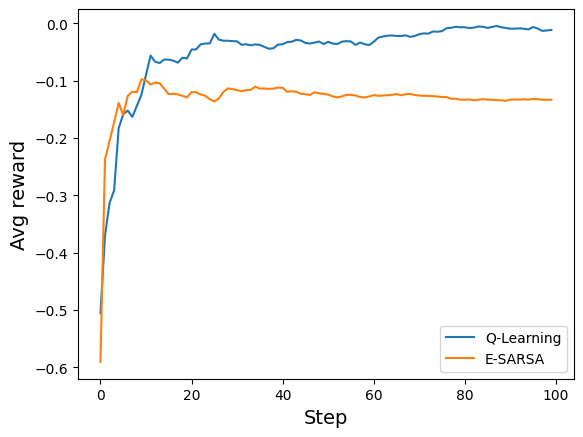

In [39]:
fig = plt.figure()
plt.plot(Data_plot1, label="Q-Learning")
plt.plot(Data_plot2, label=r"E-SARSA")
plt.xlabel("Step", fontsize=14)
plt.ylabel("Avg reward", fontsize=14)
plt.legend()
plt.show()